# Analysis

This notebook offers a quick analysis of the results produced by the genetic algorithm for a particular configuration.\
It's important to notice that results may **drastically vary** depending on the input parameters.

The reader is encouraged to test the limits of the algorithm for different configurations.

In [1]:
# Simulation
import random
import numpy as np
from tabulate import tabulate

import src.ga_utils as gu
from src.individual import generate_population

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Initial simulation parameters
dimension = 70
n_individuals = 300
moves = 10
genes = 30
max_generations = 300
energy = 30
food = 0.4
poison = 0.2
p_mutation = 0.05

In [3]:
def main_analysis(
    dimension: int,
    n_individuals: int,
    moves: int,
    *,
    genes: int,
    max_generations: int,
    energy: int,
    food: float,
    poison: float,
    p_mutation: float,
    randseed: int = None
):

    """
        Main function for simulation analysis
    """

    # Get input values and set variables
    D = dimension
    n_individuals = n_individuals
    moves = moves
    genes = genes
    max_generations = max_generations
    init_energy = energy
    food_fraction = food
    poison_fraction = poison
    p_mutation = p_mutation
    seed = randseed   

    # Quick check on parameters
    if not isinstance(dimension, int) or dimension <= 0:
        print(f"ERROR: Argument 'dimension' must be POSITIVE INTEGER, but {dimension} was given.")
        exit(1)
    if not isinstance(n_individuals, int) or n_individuals <= 0:
        print(f"ERROR: Argument 'n_individuals' must be POSITIVE INTEGER, but {n_individuals} was given.")
        exit(1)
    if not isinstance(moves, int) or moves <= 0:
        print(f"ERROR: Argument 'moves' must be POSITIVE INTEGER, but {moves} was given.")
        exit(1)
    if not isinstance(genes, int) or genes <= 0:
        print(f"ERROR: Argument 'genes' must be POSITIVE INTEGER, but {genes} was given.")
        exit(1)
    if not isinstance(max_generations, int) or max_generations <= 0:
        print(f"ERROR: Argument 'max_generations' must be POSITIVE INTEGER, but {max_generations} was given.")
        exit(1)
    if not isinstance(energy, int) or energy <= 0:
        print(f"ERROR: Argument 'energy' must be POSITIVE INTEGER, but {energy} was given.")
        exit(1)
    if not isinstance(food, float) or not (0 < food < 1):
        print(f"ERROR: Argument 'food' must be FLOAT in (0,1), but {food} was given.")
        exit(1)
    if not isinstance(poison, float) or not (0 < poison < 1):
        print(f"ERROR: Argument 'poison' must be FLOAT in (0,1), but {poison} was given.")
        exit(1)
    if not isinstance(p_mutation, float) or not (0 < p_mutation < 1):
        print(f"ERROR: Argument 'poison' must be FLOAT in (0,1), but {p_mutation} was given.")
        exit(1)
    if randseed is not None:
        if not isinstance(randseed, int) or randseed <= 0:
            print(f"ERROR: Argument 'randseed' must be POSITIVE INTEGER or NONE, but {randseed} was given.")
            exit(1)

    # Print warning if grid near saturation
    grid_sat = food_fraction + poison_fraction
    if grid_sat >= 1:
        raise ValueError (
            "Grid over-saturated with poison and food.",
            f"Note thah 'food_fraction + poison_fraction' must be less that 1, but {grid_sat} was given.")
    elif grid_sat >= 0.85:
        print("\nWARNING: Grid near saturation. Computation could be slow!") 

    # Print input parameters
    values = [
        D,
        n_individuals,
        moves,
        genes,
        init_energy,
        food_fraction,
        poison_fraction,
        p_mutation,
        max_generations
    ] + ["None" if seed == None else seed]

    names = [
        "Grid dimension",
        "Population size",
        "Steps per generation",
        "Genes",
        "Initial energy",
        "Food fraction",
        "Poison fraction",
        "Probability of mutation",
        "Limit generation",
        "Random seed"
    ]

    appo_tabulate = [[name, val] for name, val in zip(names, values)]

    print("Genetic Algorithm to develop survival instinct - Input parameters:")
    print("...")
    print(tabulate(appo_tabulate, headers=["Parameter", "Value"], tablefmt="psql"))
    print("...")
    print("...")


    # Initialization
    random.seed(seed)
    grid = np.zeros((D,D), dtype=np.short)
    gu.distribute_food(grid, food_fraction)
    gu.distribute_poison(grid, poison_fraction)

    population = generate_population(n_individuals, init_energy, genes, D)


    # Run simulation (while at least one individual is alive or max number of genertion is reached)
    index_generations = 0
    learning_pct, learning_poison_pct, learning_neutral_pct = [], [], []
    mean_energy, max_energy_ind, min_energy_ind, std_energy = [], [], [], []
    
    while gu.is_population_alive(population) and index_generations < max_generations:
        # Check the learning process
        learning_pct.append(gu.learning_percentage(population))
        learning_poison_pct.append(gu.poison_percentage(population))
        learning_neutral_pct.append(gu.neutral_percentage(population))
        mean_energy.append(gu.avg_energy(population))
        max_energy_ind.append(gu.max_energy_individual(population).energy)
        min_energy_ind.append(gu.min_energy_individual(population).energy)

        for _ in range(moves):
            for ind in population:
                ind.move(grid)

        population = gu.update_population(population, p_mutation)
        gu.distribute_food(grid, food_fraction)
        gu.distribute_poison(grid, poison_fraction)

        index_generations += 1

    # Print results in tabular form
    final_values = [
        "{:.1f}".format(learning_pct[0]),
        "{:.1f}".format(learning_pct[-1]),
        "{:.1f}".format(learning_poison_pct[0]),
        "{:.1f}".format(learning_poison_pct[-1])
    ]

    final_names = [
        "Learning food percentage (start)",
        "Learning food percentage (end)",
        "Learning poison percentage (start)",
        "Learning poison percentage (end)"
    ]

    appo_tabulate = [[name, val] for name, val in zip(final_names, final_values)]

    print(f"Results after {index_generations} generations")
    print("...")
    print(tabulate(appo_tabulate, headers=["Parameter", "Value"], tablefmt="psql"))
    print("...")

    return {
        "learning": (learning_pct, learning_poison_pct, learning_neutral_pct),
        "energy": (mean_energy, max_energy_ind, min_energy_ind, std_energy)
    }

In [4]:
# Run a batch simulation with different random seeds
results = []

for seed in range(10, 20, 1):
    results.append(
        main_analysis(
            dimension=dimension,
            n_individuals=n_individuals,
            moves=moves,
            genes=genes,
            max_generations=max_generations,
            energy=energy,
            food=food,
            poison=poison,
            p_mutation=p_mutation,
            randseed=seed
        )
    )

Genetic Algorithm to develop survival instinct - Input parameters:
...
+-------------------------+---------+
| Parameter               |   Value |
|-------------------------+---------|
| Grid dimension          |   70    |
| Population size         |  300    |
| Steps per generation    |   10    |
| Genes                   |   30    |
| Initial energy          |   30    |
| Food fraction           |    0.4  |
| Poison fraction         |    0.2  |
| Probability of mutation |    0.05 |
| Limit generation        |  300    |
| Random seed             |   10    |
+-------------------------+---------+
...
...
Results after 300 generations
...
+------------------------------------+---------+
| Parameter                          |   Value |
|------------------------------------+---------|
| Learning food percentage (start)   |    32.8 |
| Learning food percentage (end)     |    92.8 |
| Learning poison percentage (start) |    33.5 |
| Learning poison percentage (end)   |     2.2 |
+-----------

Results after 300 generations
...
+------------------------------------+---------+
| Parameter                          |   Value |
|------------------------------------+---------|
| Learning food percentage (start)   |    33.5 |
| Learning food percentage (end)     |    91.2 |
| Learning poison percentage (start) |    33   |
| Learning poison percentage (end)   |     1.3 |
+------------------------------------+---------+
...
Genetic Algorithm to develop survival instinct - Input parameters:
...
+-------------------------+---------+
| Parameter               |   Value |
|-------------------------+---------|
| Grid dimension          |   70    |
| Population size         |  300    |
| Steps per generation    |   10    |
| Genes                   |   30    |
| Initial energy          |   30    |
| Food fraction           |    0.4  |
| Poison fraction         |    0.2  |
| Probability of mutation |    0.05 |
| Limit generation        |  300    |
| Random seed             |   19    |
+----

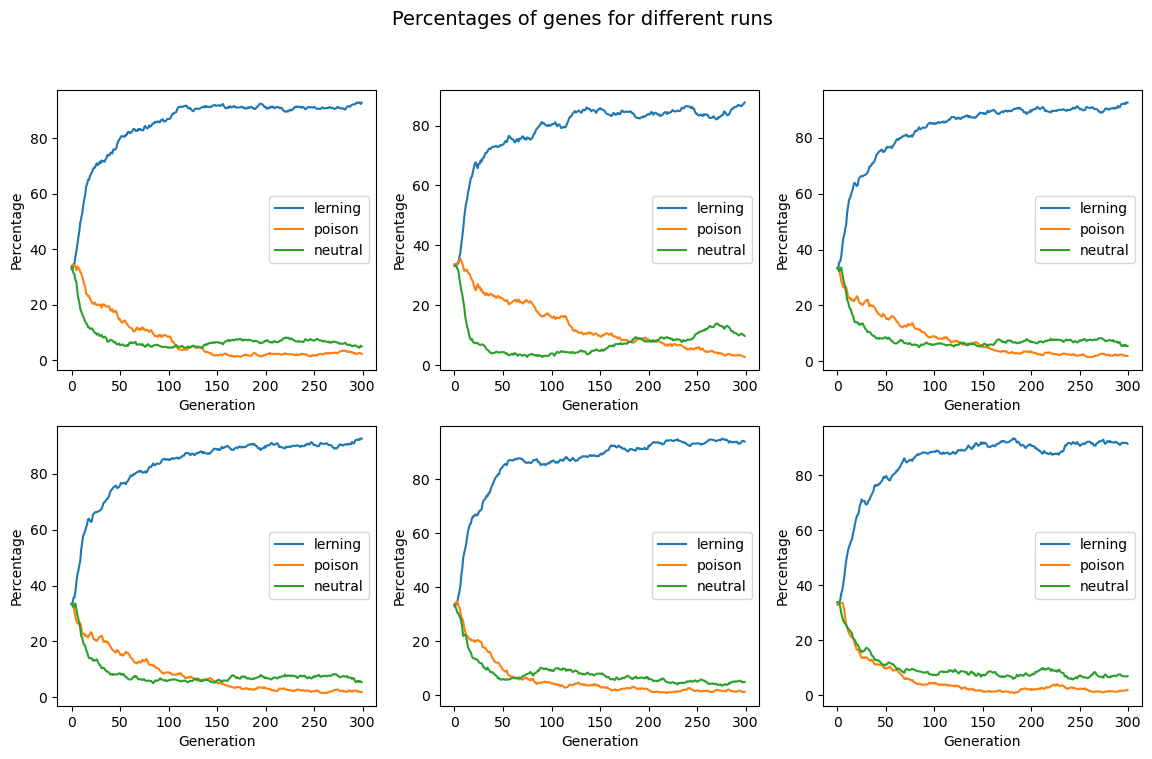

In [5]:
# Learning percentages
fig, axs = plt.subplots(2,3,figsize=(14,8))
fig.suptitle('Percentages of genes for different runs', fontsize=14)

for i in range(2):
    for j in range(3):
        axs[i][j].plot(list(range(len(results[2*i+ j]['learning'][0]))), results[2*i+ j]['learning'][0], label='lerning')
        axs[i][j].plot(list(range(len(results[2*i+ j]['learning'][1]))), results[2*i+ j]['learning'][1], label='poison')
        axs[i][j].plot(list(range(len(results[2*i+ j]['learning'][2]))), results[2*i+ j]['learning'][2], label='neutral')
        axs[i][j].set_xlabel('Generation')
        axs[i][j].set_ylabel('Percentage')
        axs[i][j].legend()

plt.show()

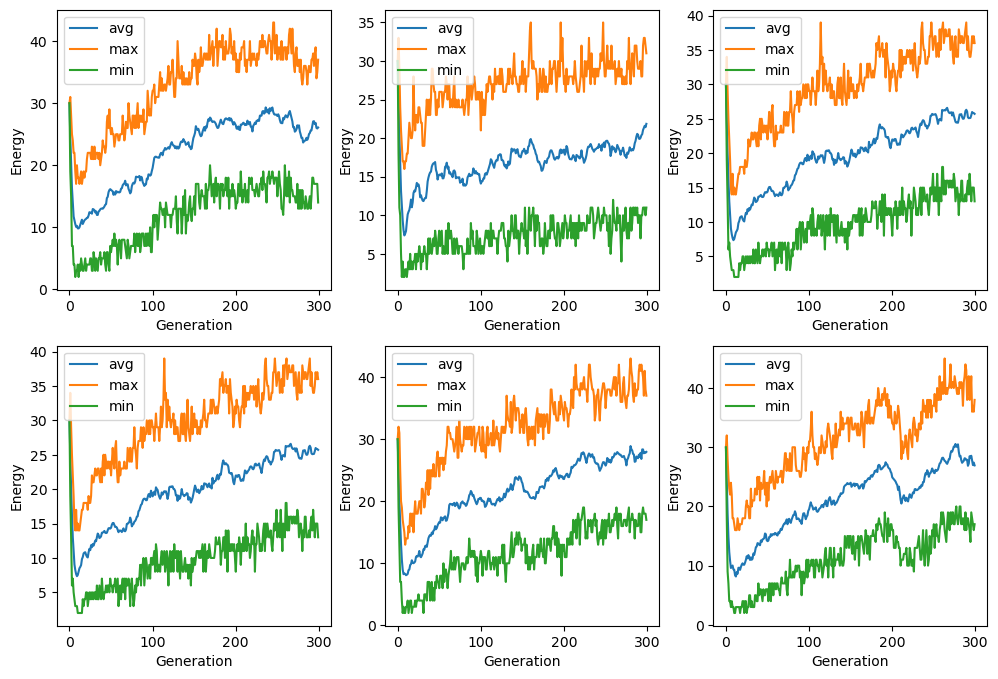

In [6]:
# Energy
fig, axs = plt.subplots(2,3, figsize=(12,8))

for i in range(2):
    for j in range(3):
        axs[i][j].plot(list(range(len(results[2*i+ j]['energy'][0]))), results[2*i+ j]['energy'][0], label='avg')
        axs[i][j].plot(list(range(len(results[2*i+ j]['energy'][1]))), results[2*i+ j]['energy'][1], label='max')
        axs[i][j].plot(list(range(len(results[2*i+ j]['energy'][2]))), results[2*i+ j]['energy'][2], label='min')
#         axs[i][j].plot(list(range(len(results[2*i+ j]['energy'][3]))), results[2*i+ j]['energy'][3], label='std')
        axs[i][j].set_xlabel('Generation')
        axs[i][j].set_ylabel('Energy')
        axs[i][j].legend()

plt.show()

In [7]:
# General average
general_lr, general_lp, general_ln = [], [], []
general_max, general_min = [], []

for run in results:
    general_max.append(run['energy'][1])
    general_min.append(run['energy'][2])
    general_lr.append(run['learning'][0])
    general_lp.append(run['learning'][1])
    general_ln.append(run['learning'][2])

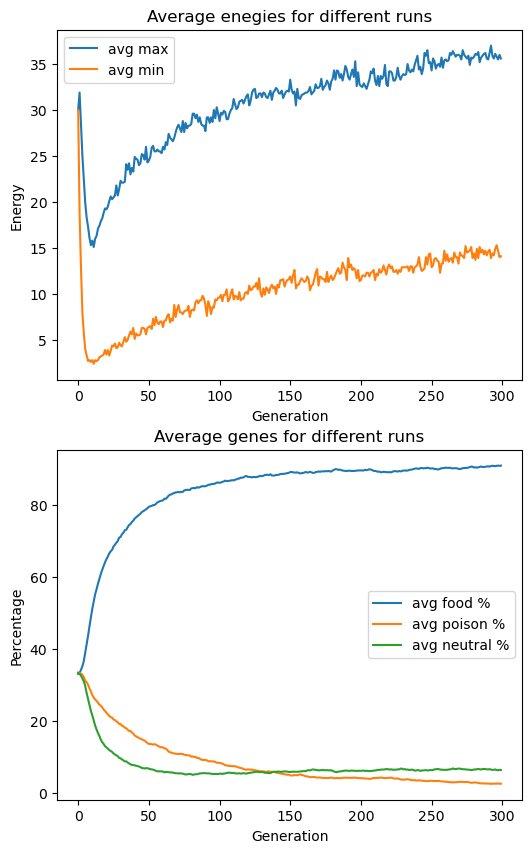

In [8]:
# Plots for average between different runs
fig, axs = plt.subplots(2,figsize=(6,10))

axs[0].plot(list(range(np.mean(general_max, axis=0).shape[0])), np.mean(general_max, axis=0), label='avg max')
axs[0].plot(list(range(np.mean(general_min, axis=0).shape[0])), np.mean(general_min, axis=0), label='avg min')
axs[0].set_title('Average enegies for different runs')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Energy')
axs[0].legend()

axs[1].plot(list(range(np.mean(general_lr, axis=0).shape[0])), np.mean(general_lr, axis=0), label='avg food %')
axs[1].plot(list(range(np.mean(general_lp, axis=0).shape[0])), np.mean(general_lp, axis=0), label='avg poison %')
axs[1].plot(list(range(np.mean(general_ln, axis=0).shape[0])), np.mean(general_ln, axis=0), label='avg neutral %')
axs[1].set_title('Average genes for different runs')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Percentage')
axs[1].legend()

plt.show()

# Conclusion

The reported graphs show that the genetic algorithm is working properly. The **fitness function** (i.e. the energy of an individual) increases over time, both its maximum and minimum value. Moreover, the learning percentage is over $80\%$ shortly after $100$ generations, confirming that the populations is evolving toward fitter individuals.\
It is interesting to notice that the percentage for *neutral* is higher that the percentage for *poison*. Again, this is an additional proof that the algorithm works, since an individual should always choose an empty spot on the grid over a poisoned one (it's easy to see that the fittest individual is $[1,\dots 1,0]$).